In [5]:
import mne
from IPython.display import display, HTML
import mat73
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import importlib
import data_utils
from data_utils import time_series_concat, fooof_exponent_compute, power_spectrum_and_aperiodic, nan_sanity_check, p_value_epi_vs_hc, permutation_ttest
importlib.reload(data_utils)
import matplotlib.pyplot as plt
from fooof import FOOOF, FOOOFGroup
from plot_functions import reorganize_roi_gradient, fill, reorder_hemispheres


In [ ]:
### loading the original EPI patients .mat data: this is used only to extract the epilepsy type for each subject ###
data_epi = mat73.loadmat("data/EPI_data.mat") #loading .mat epileptic patients data 
data_epi = data_epi['EPI_data']


epi_labels = [int(value[2]) for value in data_epi] # 1: left_epi, 2: right_epi, 3: bilateral_epi
key_labels = [f"sub{i+1}" for i in range(len(epi_labels))]
epi_labels_dict = dict(zip(key_labels, epi_labels))

del(data_epi) # removing data_epi variable to save memory

#### **Creating the data matrices and calculating FOOOF exponents for each subject ROIs**

In [10]:
freq_range = [1, 35]

HC_data_np = np.load('data/clean_concatenated_HC.npy')
EPI_data_np = np.load('data/clean_concatenated_EPI.npy')

fooof_dict_HC = fooof_exponent_compute(HC_data_np, freq_range = freq_range)
fooof_dict_EPI = fooof_exponent_compute(EPI_data_np, freq_range = freq_range)

data_HC_list = [list(value) for value in fooof_dict_HC.values()]
data_EPI_list = [list(value) for value in fooof_dict_EPI.values()]

### check for nan values in dict deriving from unsuccesful FOOOF fits or other errors ###
nan_sanity_check(fooof_dict_HC, 'HC')
nan_sanity_check(fooof_dict_EPI, 'EPI')

FOOOF exponents calculation completed
FOOOF exponents calculation completed
No Nan values present in group HC
No Nan values present in group EPI


In [4]:
### Loading of the already calculated FOOOF exponents dictionaries
with open('fooof_data_HC_1_35.pkl', 'rb') as file:
    fooof_dict_HC = pickle.load(file)
with open('fooof_data_EPI_1_35.pkl', 'rb') as file:
    fooof_dict_EPI = pickle.load(file)


data_HC_list = [list(value) for value in fooof_dict_HC.values()]
data_EPI_list = [list(value) for value in fooof_dict_EPI.values()]

#### **Permutation T-test and cortical plot of the results**

In [ ]:
# Number of variables (ROIs of Desikan-Killiany atlas)
num_variables = 68
# Number of permutations
num_permutations = 5000

t_all_EPI, p_all_EPI = permutation_ttest(matrix_EPI = data_EPI_list, matrix_HC = data_HC_list, num_permutations = num_permutations, num_variables = num_variables)

# applying ROI-wisr FDR correction 
reject, corrected_p_values_all_EPI = mne.stats.fdr_correction(p_all_EPI, alpha=0.05, method="indep")
mask_all_EPI = t_all_EPI*reject

In [8]:
### Dividing the Epileptic FOOOF group into 3 sub-groups based on specific 
### epilepsy sub-diagnosis {left_TLE: 1, right_TLE: 2, bilateral_EPI: 3}
left_epi_1_35 = [fooof_dict_EPI[key] for key in fooof_dict_EPI if epi_labels_dict[key]==1]
right_epi_1_35 = [fooof_dict_EPI[key] for key in fooof_dict_EPI if epi_labels_dict[key]==2]
bilat_epi_1_35 = [fooof_dict_EPI[key] for key in fooof_dict_EPI if epi_labels_dict[key]==3]

alpha = 0.05
num_permutations = 5000
# Applying a ROI-wise permuted T-test to the EPI sub-groups vs HC group
print('####### Left TLE group analysis #######')
t_left_EPI, p_left_EPI = permutation_ttest(matrix_EPI = left_epi_1_35, matrix_HC = data_HC_list, num_permutations = num_permutations, num_variables = num_variables)
print('\n####### Right TLE group analysis #######')
t_right_EPI, p_right_EPI = permutation_ttest(matrix_EPI = right_epi_1_35, matrix_HC = data_HC_list, num_permutations = num_permutations, num_variables = num_variables)
print('\n####### Bilateral TLE group analysis #######')
t_bilat_EPI, p_bilat_EPI = permutation_ttest(matrix_EPI = bilat_epi_1_35, matrix_HC = data_HC_list, num_permutations = num_permutations, num_variables = num_variables)

# applying FDR correction 
reject_left, corrected_p_values_left_EPI = mne.stats.fdr_correction(p_left_EPI, alpha=0.05, method="indep") ; mask_left_EPI = t_left_EPI*reject_left
reject_right, corrected_p_values_right_EPI = mne.stats.fdr_correction(p_right_EPI, alpha=0.05, method="indep") ; mask_right_EPI = t_right_EPI*reject_right
reject_bilat, corrected_p_values_bilat_EPI = mne.stats.fdr_correction(p_bilat_EPI, alpha=0.05, method="indep") ; mask_bilat_EPI = t_bilat_EPI*reject_bilat

####### Left TLE group analysis #######


ROIs EPI vs HC permuted t-value calculation: 100%|██████████| 68/68 [01:37<00:00,  1.43s/it]



####### Right TLE group analysis #######


ROIs EPI vs HC permuted t-value calculation: 100%|██████████| 68/68 [01:37<00:00,  1.43s/it]



####### Bilateral TLE group analysis #######


ROIs EPI vs HC permuted t-value calculation: 100%|██████████| 68/68 [01:37<00:00,  1.43s/it]


In [9]:
plot_masks = [mask_all_EPI, mask_left_EPI, mask_right_EPI, mask_bilat_EPI]
interactive = True
### to correctly plot the gradients obtained from BrainStorm data some indeces transformations are necessary with reorder_emispheres() and reorganize_roi_gradients()
from enigmatoolbox.utils.parcellation import parcel_to_surface, surface_to_parcel
from enigmatoolbox.plotting import plot_cortical

final_masks = []
for mask in plot_masks:
    reorganized_mask = parcel_to_surface(reorganize_roi_gradient(reorder_hemispheres(mask)), 'aparc_fsa5')
    final_masks.append(reorganized_mask)

# Project the results on the surface brain
plot_cortical(array_name=final_masks, surface_name="fsa5", size=(4000, 2800), background=(1,1,1), transparent_bg = False, interactive = True, label_text={'left':['All TLE','Left TLE', 'Right TLE,', 'Bilat TLE']}, cmap='RdBu_r', color_bar=True, scale=(1,1), zoom = 1.25, color_range= (-6.40, 6.40))

# to see the image check the image folder

In [ ]:
### Creating Lists of the rois that have a significant p-value at a specific alpha with ROI-wise FDR correction ###


labels_name = pd.read_excel('data/Desikan_regions.xlsx').values.tolist() # list of Desikan-Killiany atlas parcels

def determine_significant_rois(t_values_mask, labels_name):
  significant_indices = [index for index, roi in enumerate(t_values_mask) if roi != 0]
  significant_labels = [(labels_name[i][0], i) for i in significant_indices]
  return (significant_indices, significant_labels)

(p_indeces_all, p_significant_roi_names_all) = determine_significant_rois(mask_all_EPI, labels_name)
(p_indeces_left, p_significant_roi_names_left) = determine_significant_rois(mask_left_EPI, labels_name)
(p_indeces_right, p_significant_roi_names_right) = determine_significant_rois(mask_right_EPI, labels_name)
(p_indeces_bilat, p_significant_roi_names_bilat) = determine_significant_rois(mask_bilat_EPI, labels_name)

print(f"The {len(p_indeces_all)} ROIs with a significant p-value (alpha = {alpha}, FDR CORRECTED) are: \n {[roi[0] for roi in p_significant_roi_names_all]}")

In [42]:
### Creating a dataframe that assign value True if the ROI has significant p-value and False otherwise, for each epileptic patients group ### 
labels = [parcel_name[0] for parcel_name in labels_name]
p_values_for_df = {
    'All TLE': p_significant_roi_names_all,
    'Left TLE': p_significant_roi_names_left,
    'Right TLE': p_significant_roi_names_right,
    'Bilat TLE': p_significant_roi_names_bilat,
}

rois_dict = {'ROIs': labels}

# Check presence of strings from vector_n in each specific vector
for column_name, vector in p_values_for_df.items():
    present_rois = [i[0] for i in vector]
    presence = [True if roi[0] in present_rois else False for roi in labels_name]
    rois_dict[column_name] = presence

# Create DataFrame from dictionary
significant_rois_df = pd.DataFrame(rois_dict)
significant_rois_df.name = 'Significant ROIs FDR corrected alpha = 0,05 for each TLE sub-group'

display(significant_rois_df)
#print(significant_rois_df.to_markdown(index=False, tablefmt='grid'))

,ROIs,All TLE,Left TLE,Right TLE,Bilat TLE
0,'bankssts L',False,True,False,True
1,'bankssts R',True,False,False,True
2,'caudalanteriorcingulate L',False,False,False,True
3,'caudalanteriorcingulate R',True,True,False,True
4,'caudalmiddlefrontal L',False,False,False,True
...,...,...,...,...,...
63,'supramarginal R',False,False,False,False
64,'temporalpole L',True,True,True,True
65,'temporalpole R',True,True,False,True
66,'transversetemporal L',True,False,False,True


**FOOOF and power spectrum plot of selected ROIs**

In [6]:
### choosing 4 different rois, one for each TLE patients group ###
significant_rois_idx_all = [26]
significant_rois_idx_left = [30]
significant_rois_idx_right = [64]
significant_rois_idx_bilat = [10]


epi_significant_rois_idx = [significant_rois_idx_all[0]] + [significant_rois_idx_left[0]] + [significant_rois_idx_right[0]] + [significant_rois_idx_bilat[0]]
print(f'The chosen ROIs for the comparison are: {[labels_name[i][0] for i in epi_significant_rois_idx]}')

EPI_dict, HC_dict = {}, {}

concat_data_EPI = np.load('data_EPI.npy')
for i in range(len(concat_data_EPI)):
    EPI_dict[f'sub{i+1}'] = concat_data_EPI[i]                         
del(concat_data_EPI);

concat_data_HC = np.load('data_HC.npy')
for i in range(len(concat_data_HC)):
    HC_dict[f'sub{i+1}'] = concat_data_HC[i]
del(concat_data_HC);

### removing the 5 subjects excluded from the original dataset
EPI_dict.pop('sub2'), EPI_dict.pop('sub18'), EPI_dict.pop('sub45'), EPI_dict.pop('sub55'), EPI_dict.pop('sub66')


The chosen ROIs for the comparison are: ["'lingual L'", "'middletemporal L'", "'temporalpole L'", "'frontalpole L'"]


(array([[ 2.70854246e-10,  2.89344534e-10,  3.15742158e-10, ...,
          4.15163743e-11,  4.18723904e-11,  4.10469266e-11],
        [ 1.33161996e-10,  2.08223542e-10,  2.42379941e-10, ...,
          1.11543892e-10,  8.24728024e-11,  5.67550061e-11],
        [-3.01555109e-10, -3.15049403e-10, -3.16112686e-10, ...,
          2.50096837e-11,  5.70375056e-11,  7.44211463e-11],
        ...,
        [ 2.07889571e-10,  3.22522392e-10,  4.36214109e-10, ...,
          2.24038235e-12,  1.03913075e-11,  4.52859554e-11],
        [-1.44057108e-10, -1.61173548e-10, -1.39277964e-10, ...,
          1.05124847e-10,  1.17914790e-10,  1.07879765e-10],
        [-3.16514447e-10, -3.28820137e-10, -2.97011745e-10, ...,
         -4.10495863e-11, -1.63735422e-11, -5.39586838e-12]]),
 array([[ 1.81286422e-11,  1.13139341e-11, -1.17177390e-12, ...,
         -6.97620654e-11, -4.96170724e-11, -3.81927434e-11],
        [ 1.15039727e-11, -2.30918955e-11, -4.89694469e-11, ...,
         -1.22200848e-10, -1.27633027e

In [ ]:
### DIVISION OF THE EPILEPTIC FOOOF GROUP IN ORIGINAL GROUP WITH ALL THE SUBJECTS, LEFT EPILEPSY, RIGHT EPILEPSY AND BILATERAL EPILEPSY

# removed subj 2, 18, 45, 55, 66
# pulire operazione già fatta
hc_1_35 = np.array([HC_dict[sub] for sub in HC_dict.keys()])
total_epi_1_35 = np.array([EPI_dict[sub] for sub in EPI_dict.keys()])
left_epi_1_35 = np.array([EPI_dict[key] for key, diagnosis in epi_labels_dict.items() if diagnosis==1 and key in EPI_dict])
right_epi_1_35 = np.array([EPI_dict[key] for key, diagnosis in epi_labels_dict.items() if diagnosis==2 and key in EPI_dict])
bilat_epi_1_35 = np.array([EPI_dict[key] for key, diagnosis in epi_labels_dict.items() if diagnosis==3 and key in EPI_dict])


# selecting only the significant rois of interest
selected_rois_hc = hc_1_35[:, epi_significant_rois_idx, :]
selected_rois_total_epi = total_epi_1_35[:, significant_rois_idx_all, :]
selected_rois_left_epi = left_epi_1_35[:, significant_rois_idx_left, :]
selected_rois_right_epi = right_epi_1_35[:, significant_rois_idx_right, :]
selected_rois_bilat_epi = bilat_epi_1_35[:, significant_rois_idx_bilat, :]

### Creating 2 dict that contains the power spectrum of the selected rois of the HC and EPI subjects 
HC_power= power_spectrum_and_aperiodic(selected_rois_hc)
EPI_power = power_spectrum_and_aperiodic(selected_rois_total_epi)
left_epi_power = power_spectrum_and_aperiodic(selected_rois_left_epi)
right_epi_power = power_spectrum_and_aperiodic(selected_rois_right_epi)
bilat_epi_power = power_spectrum_and_aperiodic(selected_rois_bilat_epi)


In [18]:
# Averaging the power spectrum of the desired ROIs per subject
HC_power_transposed = np.transpose(list(HC_power.values()), (1, 2, 0, 3)) ; averaged_HC_power = np.mean(HC_power_transposed, axis=2)
EPI_power_transposed = np.transpose(list(EPI_power.values()), (1, 2, 0, 3)) ; averaged_EPI_power = np.mean(EPI_power_transposed, axis=2)
left_epi_power_transposed = np.transpose(list(left_epi_power.values()), (1, 2, 0, 3)) ; averaged_left_epi_power = np.mean(left_epi_power_transposed, axis=2)
right_epi_power_transposed = np.transpose(list(right_epi_power.values()), (1, 2, 0, 3)) ; averaged_right_epi_power = np.mean(right_epi_power_transposed, axis=2)
bilat_epi_power_transposed = np.transpose(list(bilat_epi_power.values()), (1, 2, 0, 3)) ; averaged_bilat_epi_power = np.mean(bilat_epi_power_transposed, axis=2)

Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 1 power spectra.
Running FOOOFGroup across 4 power spectra.


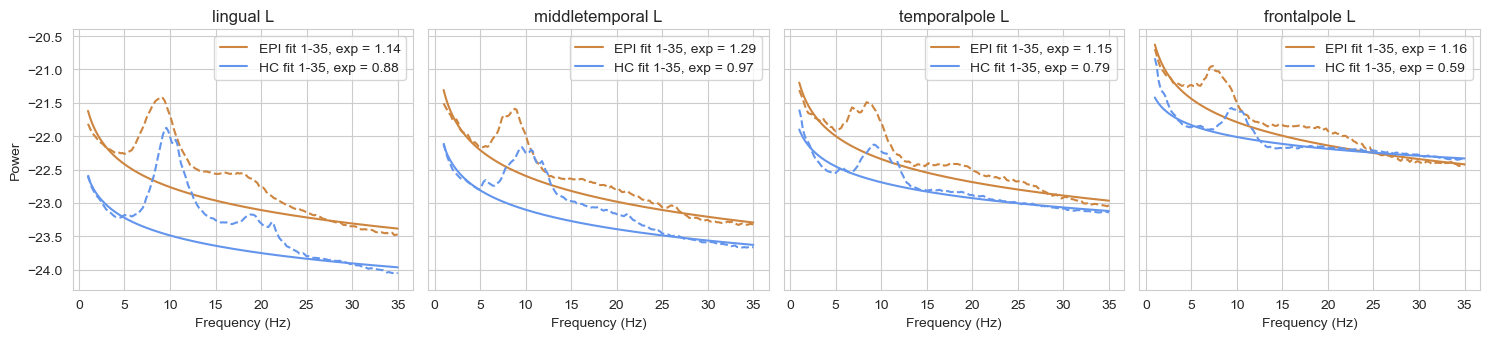

In [20]:
import fooof
from fooof import FOOOF, FOOOFGroup
from fooof.plts.spectra import plot_spectrum
 
# Initialize FOOOF object
sns.set_style('whitegrid')

freq_range_1_35 = [1, 35]
fm_EPI, fm_left_EPI, fm_right_EPI, fm_bilat_EPI= FOOOFGroup(), FOOOFGroup(), FOOOFGroup(), FOOOFGroup()
fm_HC = FOOOFGroup()

fm_EPI.fit(freqs=averaged_EPI_power[0, 0, :], power_spectra=averaged_EPI_power[1, :, :], freq_range=freq_range_1_35)
fm_left_EPI.fit(freqs=averaged_left_epi_power[0, 0, :], power_spectra=averaged_left_epi_power[1, :, :], freq_range=freq_range_1_35)
fm_right_EPI.fit(freqs=averaged_right_epi_power[0, 0, :], power_spectra=averaged_right_epi_power[1, :, :], freq_range=freq_range_1_35)
fm_bilat_EPI.fit(freqs=averaged_bilat_epi_power[0, 0, :], power_spectra=averaged_bilat_epi_power[1, :, :], freq_range=freq_range_1_35)

fm_HC.fit(freqs=averaged_HC_power[0, 0, :], power_spectra=averaged_HC_power[1, :, :], freq_range=freq_range_1_35)


fig, axes = plt.subplots(1, 4, figsize=(15, 3.5))  #2 rows, 4 columns of subplots
fooofs = [fm_EPI, fm_left_EPI, fm_right_EPI, fm_bilat_EPI]
plot_titles = np.array([labels_name[i] for i in epi_significant_rois_idx])


for j in range(axes.shape[0]):
    fm_HC_singular = fm_HC.get_fooof(ind=j, regenerate=True)
    fm_epi_singular = fooofs[j].get_fooof(ind=0, regenerate=True)
    axes[j].plot(fm_epi_singular.freqs, fm_epi_singular.power_spectrum, color='peru', linestyle='dashed')
    axes[j].plot(fm_epi_singular.freqs, fm_epi_singular._ap_fit,
            label=f'EPI fit 1-35, exp = {np.round(fm_epi_singular.aperiodic_params_[1], 2)}', color='peru')
    axes[j].plot(fm_HC_singular.freqs, fm_HC_singular.power_spectrum, color='cornflowerblue', linestyle='dashed')
    axes[j].plot(fm_HC_singular.freqs, fm_HC_singular._ap_fit,
            label=f'HC fit 1-35, exp = {np.round(fm_HC_singular.aperiodic_params_[1], 2)}', color='cornflowerblue')
    axes[j].set_ylim(-24.3, -20.4)
    #axes[i, j].set_xlim(0, 36)
    axes[j].legend()
    title = plot_titles[j][0].replace("'", "")
    axes[j].set_title(title, fontsize = 12)
    axes[j].set_xlabel('Frequency (Hz)')
    if j == 0:
        axes[j].set_ylabel('Power')

    if j != 0:
        plt.setp(axes[j].get_yticklabels(), visible=False)
plt.tight_layout()

#plt.savefig('significant rois all. left, right, bilat TLE vs HC alpha=0,05 FDR corrected power + fit.svg', format='svg')